## Example of THz field orientation of OCS molecule

... using THz pulse profile from Fig 4 of https://doi.org/10.1364/OE.24.021059

In [1]:
from richmol.rot import Molecule, solve, LabTensor
from richmol.tdse import TDSE
from richmol.convert_units import AUdip_x_Vm_to_invcm
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'figure.autolayout': True})

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


<Figure size 504x360 with 0 Axes>

#### Field-free rotational solutions and matrix elements

In [2]:
ocs = Molecule()

ocs.XYZ = ("angstrom",
           "C",  0.0,  0.0,  -0.522939783141,
           "O",  0.0,  0.0,  -1.680839357,
           "S",  0.0,  0.0,  1.037160128)

# molecular-frame dipole moment (in au)
ocs.dip = [0, 0, -0.31093]

# molecular-frame polarizability tensor (in au)
#ocs.pol = [[25.5778097, 0, 0], [0, 25.5778097, 0], [0, 0, 52.4651140]]

Jmax = 10
sol = solve(ocs, Jmax=Jmax)

# laboratory-frame dipole moment operator
dip = LabTensor(ocs.dip, sol)

# laboratory-frame polarizability tensor
#pol = LabTensor(ocs.pol, sol)

# field-free Hamiltonian
h0 = LabTensor(ocs, sol)

# matrix elements of cos(theta)
cos = LabTensor("costheta", sol)

# matrix elements of cos^2(theta)-1/3
cos2 = LabTensor("cos2theta", sol)

# print state assignment
assign_bra, assign_ket = h0.assign(form="full")
state_label = []
for J, sym, m, k in zip(*(assign_bra[key] for key in ("J", "sym", "m", "k"))):
    print("J =", J, "sym =", sym, "m =", m, "k =", k)

    state_label.append(f"J = {J}, m = {m}") # we will need this for labelling states when plotting state populations

J = 0.0 sym = A m = 0 k = ('0 0 0  1.000000', 0.0)
J = 1.0 sym = A m = -1 k = ('1 0 1  1.000000', 0.4068787767090083)
J = 1.0 sym = A m = 0 k = ('1 0 1  1.000000', 0.4068787767090083)
J = 1.0 sym = A m = 1 k = ('1 0 1  1.000000', 0.4068787767090083)
J = 2.0 sym = A m = -2 k = ('2 0 0  1.000000', 1.2206363301270258)
J = 2.0 sym = A m = -1 k = ('2 0 0  1.000000', 1.2206363301270258)
J = 2.0 sym = A m = 0 k = ('2 0 0  1.000000', 1.2206363301270258)
J = 2.0 sym = A m = 1 k = ('2 0 0  1.000000', 1.2206363301270258)
J = 2.0 sym = A m = 2 k = ('2 0 0  1.000000', 1.2206363301270258)
J = 3.0 sym = A m = -3 k = ('3 0 1  1.000000', 2.4412726602540515)
J = 3.0 sym = A m = -2 k = ('3 0 1  1.000000', 2.4412726602540515)
J = 3.0 sym = A m = -1 k = ('3 0 1  1.000000', 2.4412726602540515)
J = 3.0 sym = A m = 0 k = ('3 0 1  1.000000', 2.4412726602540515)
J = 3.0 sym = A m = 1 k = ('3 0 1  1.000000', 2.4412726602540515)
J = 3.0 sym = A m = 2 k = ('3 0 1  1.000000', 2.4412726602540515)
J = 3.0 sym = A m =

#### Set up THz field using field profile from Fig 4 in https://doi.org/10.1364/OE.24.021059 (digitized figure using https://apps.automeris.io/wpd/)

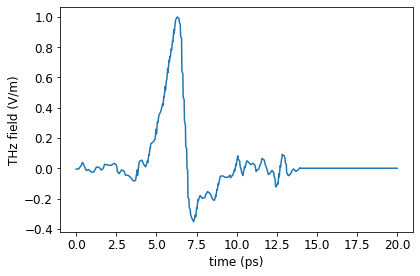

In [3]:
import csv
from scipy.interpolate import interp1d

with open('thz_field.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    _field = np.array([[float(elem.replace(',', '.')) for elem in row] for row in csv_reader])
    _field -= [np.min(_field.T[0]), 0]
    _field /= [1, np.max(_field.T[1])]
    _f_field = interp1d(*_field.T, fill_value=0, bounds_error=False)

def field_z(time, peak_field):
    return _f_field(time) * peak_field

t = np.linspace(0, 20, 1000)
plt.plot(t, field_z(t, peak_field=1))
plt.xlabel('time (ps)')
plt.ylabel('THz field (V/m)')
plt.show()

#### Solve TDSE and compute expectation values

In [4]:
tdse = TDSE(t_start=0, t_end=500, dt=0.01, t_units="ps", enr_units="invcm")

# initial state
vecs = tdse.init_state(h0, temp=0)

# set up interaction Hamiltonian
# `AUdip_x_Vm_to_invcm` converts dipole moment[au] * field[V/m] into [cm^-1]
H = -1.0 * dip * AUdip_x_Vm_to_invcm()

# matrix elements of cos(theta) and cos^2(theta) in sparse matrix form
cosmat = cos.tomat(form="full", cart="0")
cos2mat = cos2.tomat(form="full", cart="0")

peak_field = 100e6 # V/m

expval_cos = []
expval_cos2 = []
c2 = []
for i, t in enumerate(tdse.time_grid()):

    H_ = H * [0, 0, field_z(t, peak_field=peak_field)]
    #H.field([0, 0, field_z(t, peak_field=peak_field)]) # in-place update (does not create new object)

    # update vector
    vecs, t_ = tdse.update(H_, H0=h0, vecs=vecs, matvec_lib='scipy')
    #vecs, t_ = tdse.update(H, H0=h0, vecs=vecs, matvec_lib='scipy')

    # expectation value of cos(theta) and cos^2(theta)
    expval_cos.append( np.dot(np.conj(vecs[0][:]), cosmat.dot(vecs[0][:])) )
    expval_cos2.append( np.dot(np.conj(vecs[0][:]), cos2mat.dot(vecs[0][:])) + 1/3 )

    # populations
    c2.append(abs(vecs[0][:])**2)

    if i % 1000 == 0:
        print(f'{t} ps')

0.005 ps
10.005 ps
20.005 ps
30.005 ps
40.005 ps
50.005 ps
60.005 ps
70.005 ps
80.005 ps
90.005 ps
100.005 ps
110.005 ps
120.005 ps
130.005 ps
140.005 ps
150.005 ps
160.005 ps
170.005 ps
180.005 ps
190.005 ps
200.005 ps
210.005 ps
220.005 ps
230.005 ps
240.005 ps
250.005 ps
260.005 ps
270.005 ps
280.005 ps
290.005 ps
300.005 ps
310.005 ps
320.005 ps
330.005 ps
340.005 ps
350.005 ps
360.005 ps
370.005 ps
380.005 ps
390.005 ps
400.005 ps
410.005 ps
420.005 ps
430.005 ps
440.005 ps
450.005 ps
460.005 ps
470.005 ps
480.005 ps
490.005 ps


#### Plot expectation values of $\cos\theta$ and $\cos^2\theta$

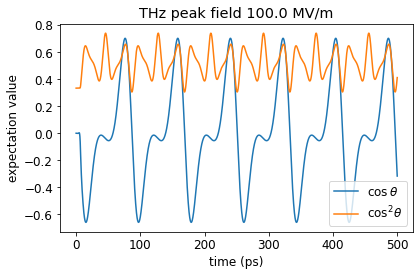

In [5]:
plt.plot(tdse.time_grid(), expval_cos, label='$\\cos\\theta$')
plt.plot(tdse.time_grid(), expval_cos2, label='$\\cos^2\\theta$')
plt.xlabel('time (ps)')
plt.ylabel('expectation value')
plt.title(f'THz peak field {peak_field/1e6} MV/m')
plt.legend()
plt.show()

#### Plot state populations

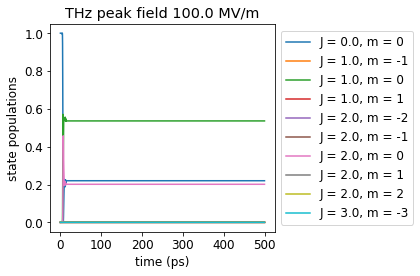

In [6]:
no_states = 10
c2 = np.array(c2)
plt.plot(tdse.time_grid(), c2[:, :no_states], label=state_label[:no_states])
plt.xlabel('time (ps)')
plt.ylabel('state populations')
plt.title(f'THz peak field {peak_field/1e6} MV/m')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()